![hybrid.jpg](hybrid.jpg)

In [269]:
import pandas as pd
import numpy as np
import plotly.express as px
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import Birch
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from catboost import Pool


In [26]:
user_data = pd.read_csv("../data/customers.csv").dropna()
actions_data = pd.read_csv("../data/dataset.csv").dropna().astype(int)
cars_data = pd.read_csv("../data/cars_about.csv").dropna()

## Preprocess user data

In [27]:
user_data

,customer_id,gender,married,age,graduated,profession,familySize
0,45,Male,No,22,No,Healthcare,4.0
1,817,Female,Yes,38,Yes,Engineer,3.0
2,495,Female,Yes,67,Yes,Engineer,1.0
3,36,Male,Yes,67,Yes,Lawyer,2.0
4,76,Female,Yes,40,Yes,Entertainment,6.0
...,...,...,...,...,...,...,...
315,353,Male,Yes,74,Yes,Lawyer,2.0
316,411,Female,No,30,No,Homemaker,4.0
317,297,Female,No,37,Yes,Artist,2.0
318,186,Female,No,22,No,Marketing,1.0


In [28]:
# Identify the categorical columns
cat_cols = ['gender', 'married', 'graduated', 'profession']

# Convert the categorical columns to numerical using Label Encoding
for col in cat_cols:
    le = LabelEncoder()
    user_data[col] = le.fit_transform(user_data[col])

user_data

,customer_id,gender,married,age,graduated,profession,familySize
0,45,1,0,22,0,5,4.0
1,817,0,1,38,1,2,3.0
2,495,0,1,67,1,2,1.0
3,36,1,1,67,1,7,2.0
4,76,0,1,40,1,3,6.0
...,...,...,...,...,...,...,...
315,353,1,1,74,1,7,2.0
316,411,0,0,30,0,6,4.0
317,297,0,0,37,1,0,2.0
318,186,0,0,22,0,8,1.0


## Preprocess cars data

In [72]:
cars_data = pd.read_csv("../data/cars_about.csv").dropna()

cars_data["brand"] = cars_data.car_model.apply(lambda a: a.split()[0])
cars_data = cars_data.drop(columns=["car_model", "engine", "car_id"])
cars_data["price"] = cars_data['price'].apply(lambda a: int(a[1:]))

cars_data['used_label'] = cars_data["used_label"].apply(lambda a: 1 if a=="Used" else 0)
# Identify the categorical columns
car_cat_cols = ['exteriorColor', 'interiorColor', 'drivetrain', 'fuelType', 'transmission', 'brand']

# Convert the categorical columns to numerical using Label Encoding
for col in car_cat_cols:
    le = LabelEncoder()
    cars_data[col] = le.fit_transform(cars_data[col])

cars_data

,used_label,price,exteriorColor,interiorColor,drivetrain,minMPG,maxMPG,fuelType,transmission,mileage,brand
0,1,39,139,11,4,19.0,27.0,3,20,29403.0,28
1,1,49,145,11,3,19.0,24.0,3,2,32929.0,10
2,1,41,62,11,3,15.0,21.0,3,20,23173.0,25
3,1,28,66,83,4,29.0,35.0,3,28,10598.0,13
4,1,49,53,10,4,20.0,27.0,3,20,28137.0,19
...,...,...,...,...,...,...,...,...,...,...,...
399,1,33,46,11,3,18.0,25.0,3,20,43807.0,16
400,0,30,163,57,2,34.0,30.0,5,28,41944.0,28
401,1,35,11,11,2,22.0,29.0,3,24,49386.0,5
402,1,35,168,49,3,16.0,22.0,3,9,115795.0,6


## Preprocess actions data

In [32]:
actions_data

,user_id,item_id,interaction
0,0,0,1
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
8170,70,402,0
8171,71,402,0
8172,72,402,0
8173,73,402,0


In [43]:
actions_pivot_table = pd.pivot_table(actions_data.sort_values(by="item_id"), values='interaction', index='user_id', columns='item_id').fillna(0)

In [46]:
actions_data.item_id.nunique()

109

In [35]:
px.imshow(actions_pivot_table, width=1800, height=800)

## CatBoost inputs

1. собираю фичи топ n понравившихся авто
2. конкатенирую фичи понравившихся авто с таргет авто
3. делаю бинарную классификацию 

In [247]:
N_POSITIVE = 10

In [248]:
column_names = []
cat_columns = ['used_label', 'exteriorColor', 'interiorColor', 'drivetrain', 'fuelType', 'transmission', 'brand']
cat_features = []

for index in range(N_POSITIVE):
    for column in cars_data.columns:
        column_names.append(f"car_{index}_{column}")
        
for column in cars_data.columns:
    column_names.append(f"target_{column}")

for column in column_names:
    for c_column in cat_columns:
        if c_column in column:
            cat_features.append(column)
        
dataset = pd.DataFrame(columns=column_names + ["interaction"])

for user_id in actions_data.user_id.unique():
    for target_car_id in actions_data.item_id.unique():
        # len(cars_data.columns) * (N_POSITIVE + 1))
        matrix_features = []
        features = []
        current_positive_samples = actions_data.loc[actions_data.user_id == user_id].query(f"item_id != {target_car_id}").query("interaction == 1")

        if len(current_positive_samples) < N_POSITIVE: continue

        for car_id in current_positive_samples.sample(N_POSITIVE).item_id.to_list():
            matrix_features.append(cars_data.iloc[car_id].to_list())
        matrix_features.append(cars_data.iloc[target_car_id].to_list())
        matrix_features.append(int(actions_data.loc[actions_data.item_id == target_car_id].query(f"user_id == {user_id}").interaction))
        
        for item in matrix_features:
            if isinstance(item, list):
                for elem in item:
                    features.append(elem)
            else:
                features.append(item)
        dataset = pd.concat([dataset, pd.DataFrame.from_records([dict(zip(dataset.columns, features))])])

dataset = dataset.astype(int)

In [238]:
dataset.shape

(6931, 67)

In [250]:
dataset.interaction.value_counts()

0    2139
1     199
Name: interaction, dtype: int64

In [251]:
balanced_dataset = pd.concat([dataset.loc[dataset.interaction == 1], dataset.loc[dataset.interaction == 0].sample(int(dataset.interaction.value_counts()[1] * 1.5))])

In [252]:
balanced_dataset

,car_0_used_label,car_0_price,car_0_exteriorColor,car_0_interiorColor,car_0_drivetrain,car_0_minMPG,car_0_maxMPG,car_0_fuelType,car_0_transmission,car_0_mileage,...,target_exteriorColor,target_interiorColor,target_drivetrain,target_minMPG,target_maxMPG,target_fuelType,target_transmission,target_mileage,target_brand,interaction
0,0,46,167,11,5,15,24,3,20,25642,...,11,83,5,17,23,3,6,105469,28,1
0,1,23,11,83,5,17,23,3,6,105469,...,131,8,2,19,26,3,24,14445,13,1
0,0,30,74,11,5,19,30,3,20,33296,...,167,11,5,15,24,3,20,25642,8,1
0,0,33,177,35,2,17,24,3,7,23046,...,114,44,4,20,27,3,20,47729,19,1
0,1,51,49,44,4,20,26,3,20,24793,...,142,37,4,17,24,3,9,28357,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,18,85,68,5,21,30,3,15,58157,...,93,62,2,21,26,3,2,5188,0,0
0,1,18,85,68,5,21,30,3,15,58157,...,99,63,3,16,19,3,6,20606,28,0
0,1,44,131,8,2,19,26,3,24,14445,...,110,83,2,20,30,3,20,21603,2,0
0,1,18,85,68,5,21,30,3,15,58157,...,66,11,4,22,29,3,9,21055,17,0


In [253]:
balanced_dataset.interaction.value_counts()

0    298
1    199
Name: interaction, dtype: int64

In [254]:
dataset.columns

Index(['car_0_used_label', 'car_0_price', 'car_0_exteriorColor',
       'car_0_interiorColor', 'car_0_drivetrain', 'car_0_minMPG',
       'car_0_maxMPG', 'car_0_fuelType', 'car_0_transmission', 'car_0_mileage',
       ...
       'target_exteriorColor', 'target_interiorColor', 'target_drivetrain',
       'target_minMPG', 'target_maxMPG', 'target_fuelType',
       'target_transmission', 'target_mileage', 'target_brand', 'interaction'],
      dtype='object', length=122)

In [255]:
cat_features

['car_0_used_label',
 'car_0_exteriorColor',
 'car_0_interiorColor',
 'car_0_drivetrain',
 'car_0_fuelType',
 'car_0_transmission',
 'car_0_brand',
 'car_1_used_label',
 'car_1_exteriorColor',
 'car_1_interiorColor',
 'car_1_drivetrain',
 'car_1_fuelType',
 'car_1_transmission',
 'car_1_brand',
 'car_2_used_label',
 'car_2_exteriorColor',
 'car_2_interiorColor',
 'car_2_drivetrain',
 'car_2_fuelType',
 'car_2_transmission',
 'car_2_brand',
 'car_3_used_label',
 'car_3_exteriorColor',
 'car_3_interiorColor',
 'car_3_drivetrain',
 'car_3_fuelType',
 'car_3_transmission',
 'car_3_brand',
 'car_4_used_label',
 'car_4_exteriorColor',
 'car_4_interiorColor',
 'car_4_drivetrain',
 'car_4_fuelType',
 'car_4_transmission',
 'car_4_brand',
 'car_5_used_label',
 'car_5_exteriorColor',
 'car_5_interiorColor',
 'car_5_drivetrain',
 'car_5_fuelType',
 'car_5_transmission',
 'car_5_brand',
 'car_6_used_label',
 'car_6_exteriorColor',
 'car_6_interiorColor',
 'car_6_drivetrain',
 'car_6_fuelType',
 'c

In [256]:
from sklearn.model_selection import train_test_split
# Split into training and validation sets
train_df, val_df = train_test_split(balanced_dataset, test_size=0.2, random_state=42)
X_train, y_train = train_df.drop(columns=['interaction']), train_df[["interaction"]]

# Split into validation and test sets
val_df, test_df = train_test_split(val_df, test_size=0.2, random_state=42)

X_val, y_val = val_df.drop(columns=['interaction']), val_df[["interaction"]]
X_test, y_test = test_df.drop(columns=['interaction']), test_df[["interaction"]]

In [257]:
X_train.shape, X_val.shape, X_test.shape

((397, 121), (80, 121), (20, 121))

In [258]:
X_train

,car_0_used_label,car_0_price,car_0_exteriorColor,car_0_interiorColor,car_0_drivetrain,car_0_minMPG,car_0_maxMPG,car_0_fuelType,car_0_transmission,car_0_mileage,...,target_price,target_exteriorColor,target_interiorColor,target_drivetrain,target_minMPG,target_maxMPG,target_fuelType,target_transmission,target_mileage,target_brand
0,0,106,67,20,2,15,23,3,24,15113,...,16,66,11,5,19,28,3,9,48605,19
0,1,20,2,44,4,21,34,3,9,73467,...,30,74,11,5,19,30,3,20,33296,8
0,1,20,158,83,5,20,29,3,15,102893,...,44,11,11,2,18,25,3,36,38336,3
0,0,46,167,11,5,15,24,3,20,25642,...,106,67,20,2,15,23,3,24,15113,22
0,1,24,147,13,3,17,22,3,6,151989,...,20,2,44,4,21,34,3,9,73467,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,24,147,13,3,17,22,3,6,151989,...,44,131,8,2,19,26,3,24,14445,13
0,0,46,167,11,5,15,24,3,20,25642,...,44,11,11,2,18,25,3,36,38336,3
0,1,44,131,8,2,19,26,3,24,14445,...,40,45,83,2,20,27,3,20,10969,30
0,1,18,85,68,5,21,30,3,15,58157,...,47,147,81,5,0,0,2,25,84000,27


In [259]:
y_train

,interaction
0,1
0,0
0,0
0,0
0,0
...,...
0,1
0,0
0,0
0,0


In [267]:
# Create CatBoost model
model = CatBoostRegressor(iterations=1000, 
                           learning_rate=0.05, 
                           # depth=5, 
                        #    loss_function='CrossEntropy', 
                           cat_features=cat_features, 
                           random_seed=42)

# Fit the model on the training data
model.fit(X_train, y_train, 
          eval_set=(X_val, y_val), 
          early_stopping_rounds=50, 
          verbose=100)

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred

0:	learn: 0.4846608	test: 0.4943363	best: 0.4943363 (0)	total: 11.7ms	remaining: 11.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4679962853
bestIteration = 37

Shrink model to first 38 iterations.


array([0.19196802, 0.33885234, 0.46256716, 0.33086841, 0.57185277,
       0.17202866, 0.1913709 , 0.24380334, 0.51417291, 0.504647  ,
       0.19021694, 0.24127441, 0.4305644 , 0.61259445, 0.5421281 ,
       0.16713503, 0.3069217 , 0.63782913, 0.40646595, 0.60355833])

/home/proton/anaconda3/envs/proton/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



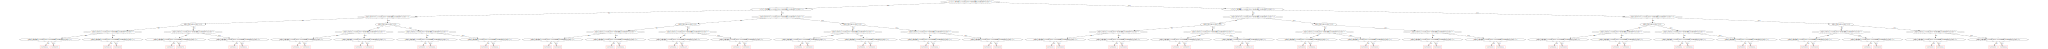

In [274]:
pool = Pool(X_test, y_test, cat_features=cat_features, feature_names=list(X_test.columns))
model.plot_tree(
    tree_idx=0,
    pool=pool
)


In [286]:
# Create CatBoost model
model = CatBoostClassifier(iterations=1000, 
                           learning_rate=0.05, 
                        #    depth=5, 
                           loss_function='CrossEntropy', 
                           cat_features=cat_features, 
                           random_seed=42)

# Fit the model on the training data
model.fit(X_train, y_train, 
          eval_set=(X_val, y_val), 
          early_stopping_rounds=50, 
          verbose=100)

# Make predictions on the test data
y_pred = model.predict(X_test)

/home/proton/anaconda3/envs/proton/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



0:	learn: 0.6806170	test: 0.6900009	best: 0.6900009 (0)	total: 13.4ms	remaining: 13.4s
100:	learn: 0.2828044	test: 0.6490723	best: 0.6205842 (50)	total: 1.1s	remaining: 9.78s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6205842143
bestIteration = 50

Shrink model to first 51 iterations.


In [297]:
submission_table = pd.DataFrame(dict(gt = y_test.interaction, pred = y_pred))

In [298]:
submission_table

,gt,pred
0,0,0
0,1,0
0,0,1
0,1,0
0,1,1
0,0,0
0,0,0
0,0,0
0,1,1
0,0,0


In [312]:
n_correct = 0
for i in range(len(submission_table)):
    current_row = list(submission_table.iloc[i])
    if current_row[0] == current_row[1]:
        n_correct += 1
print(f"test accurracy: {n_correct/len(y_test)}")

test accurracy: 0.75


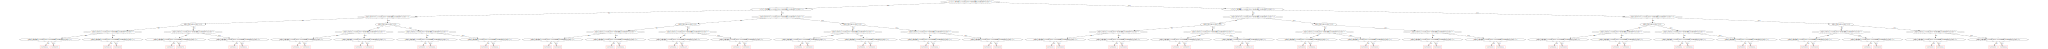

In [273]:
pool = Pool(X_test, y_test, cat_features=cat_features, feature_names=list(X_test.columns))
model.plot_tree(
    tree_idx=0,
    pool=pool
)
